In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
tesladf=pd.read_csv("teslastock.csv", parse_dates=True, index_col="date", usecols=["date", "open", "high", "low", "close", "volume"])
tesladf.head()

,open,high,low,close,volume
date,,,,,
2014-01-02,9.986667,10.165333,9.770000,10.006667,92826000
2014-01-03,10.000000,10.146000,9.906667,9.970667,70425000
2014-01-06,10.000000,10.026667,9.682667,9.800000,80416500
2014-01-07,9.841333,10.026667,9.683333,9.957333,75511500
2014-01-08,9.923333,10.246667,9.917333,10.085333,92448000


In [3]:
tesladf.size

12580

In [4]:
tesladf.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [5]:
int(tesladf.duplicated().sum())

0

In [ ]:
tesladf.dtypes

open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

In [7]:
tesladf.index = pd.to_datetime(tesladf.index)
tesladf = tesladf.asfreq("B")

In [8]:
tesladf = tesladf.fillna(method="ffill")  # Forward-fill missing data

C:\Users\iSHAN\AppData\Local\Temp\ipykernel_9172\3061281410.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tesladf = tesladf.fillna(method="ffill")  # Forward-fill missing data


In [9]:
tesladf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2607 entries, 2014-01-02 to 2023-12-29
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2607 non-null   float64
 1   high    2607 non-null   float64
 2   low     2607 non-null   float64
 3   close   2607 non-null   float64
 4   volume  2607 non-null   float64
dtypes: float64(5)
memory usage: 122.2 KB


## Exploratory Data Analysis 

In [10]:
def is_stationary(data: pd.Series):
    result=adfuller(data)
    return "the data is stationary" if result[1]<0.05 else "The data is not stationary"

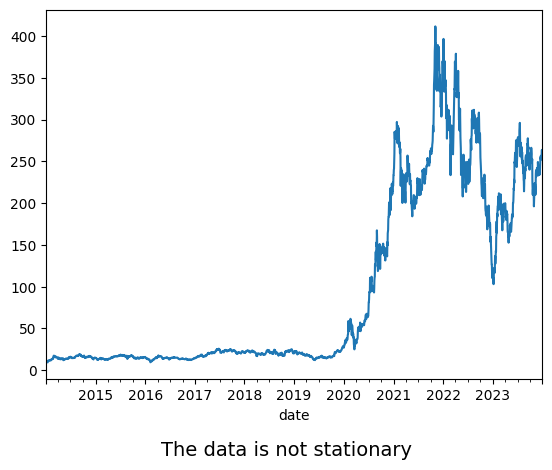

In [11]:
tesladf["open"].plot()
plt.figtext(0.5, -0.05, is_stationary(tesladf["open"]), ha="center", fontsize=14)
plt.show()

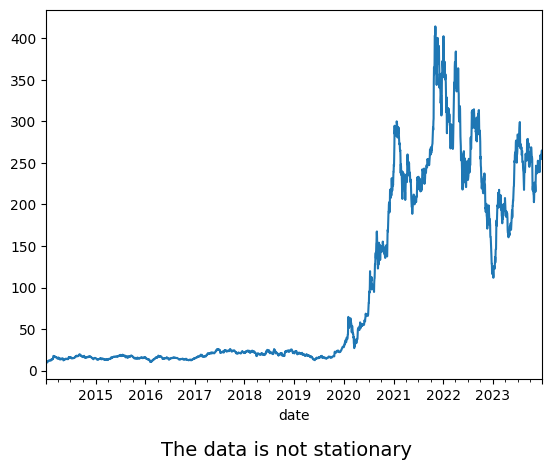

In [12]:
tesladf["high"].plot()
plt.figtext(0.5, -0.05, is_stationary(tesladf["high"]), ha="center", fontsize=14)
plt.show()

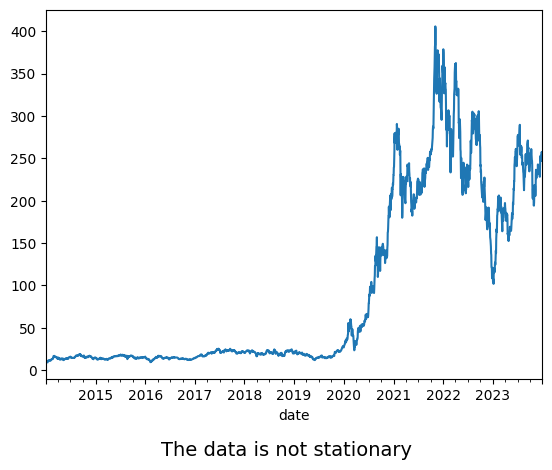

In [13]:
tesladf["low"].plot()
plt.figtext(0.5, -0.05, is_stationary(tesladf["low"]), ha="center", fontsize=14)
plt.show()

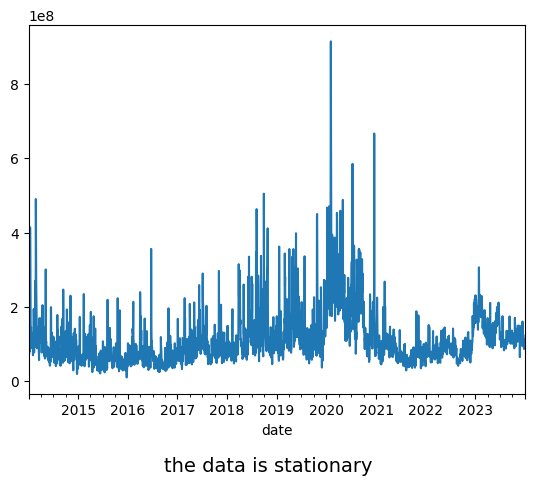

In [14]:
tesladf["volume"].plot()
plt.figtext(0.5, -0.05, is_stationary(tesladf["volume"]), ha="center", fontsize=14)
plt.show()

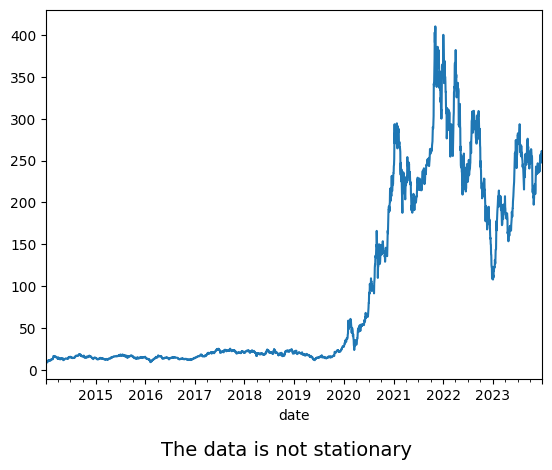

In [15]:
tesladf["close"].plot()
plt.figtext(0.5, -0.05, is_stationary(tesladf["close"]), ha="center", fontsize=14)
plt.show()

In [ ]:
{col:bool(adfuller(tesladf[col])[1]<0.05) for col in tesladf.columns}

{'open': False, 'high': False, 'low': False, 'close': False, 'volume': True}

In [17]:
tesladf["opendiff_1"]=tesladf["open"]-tesladf["open"].shift(1)

**determining the value of differencing order(d)**: number of times data is differenced to make it stationary 


In [18]:
print(is_stationary(tesladf["opendiff_1"].dropna()))#concludes differencing order value,d= 1

the data is stationary


**determining the value of Moving Average order (q)**: 
- q is number of past error terms included in the model 
- identified by Auto Correlation Plot 
- Moving Average model `tapers` towards 0 in some manner
- ACF will have non-zero autocorrelations only   

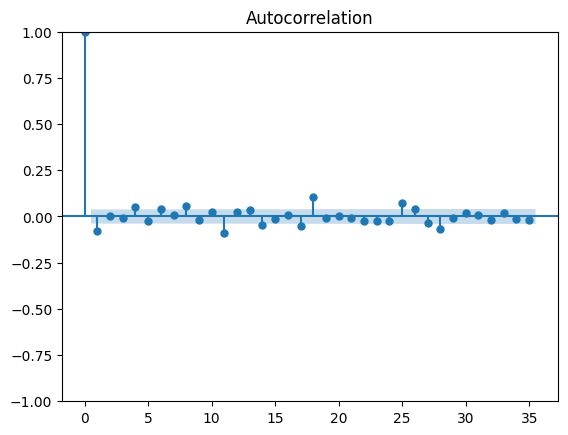

In [19]:
acf= plot_acf(tesladf["opendiff_1"].dropna()) #used to calculate Moving Average order (q)

**determining the value of Auto Regression order (p)**:
- p is number of lag values beyond two bounds
- Partial Auto Correlation Function Plot is best used for this purpose
- PACF plot for an AR model `shuts off` beyond the order of model
- in other words, most extreme lag of x which is used as predictor

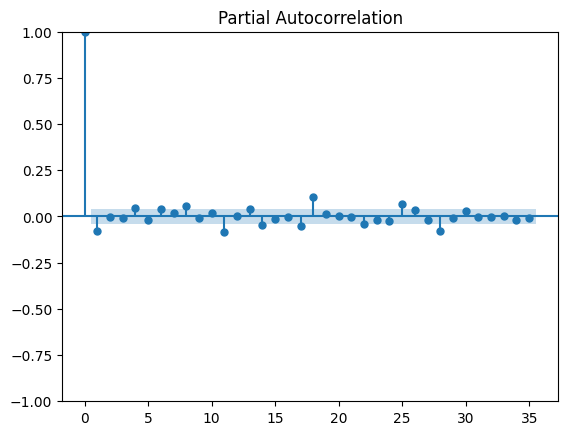

In [20]:
pacf1=plot_pacf(tesladf["opendiff_1"].dropna()) # used to calculate the Auto Regression order (p)

## Training the model

spliting the dataset into training and test data

In [21]:
tesladf["open"].size*0.75

1955.25

In [22]:
train_start_date= tesladf.index[0]
train_end_date= tesladf.index[1955]
pred_start_date = tesladf.index[1956]
pred_end_date= tesladf.index[-1]

In [23]:
traindata=tesladf.loc[train_start_date:train_end_date, "open"]
testdata=tesladf.loc[pred_start_date:pred_end_date, "open"]

In [24]:
traindata.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1956 entries, 2014-01-02 to 2021-07-01
Freq: B
Series name: open
Non-Null Count  Dtype  
--------------  -----  
1956 non-null   float64
dtypes: float64(1)
memory usage: 30.6 KB


In [25]:
testdata.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 651 entries, 2021-07-02 to 2023-12-29
Freq: B
Series name: open
Non-Null Count  Dtype  
--------------  -----  
651 non-null    float64
dtypes: float64(1)
memory usage: 10.2 KB


**ARIMA**: Auto Regressive Integrated Moving Average
- Works best with stationary data 
- Stationary data: Mean, variance and autocorrelation remain constant overtime 

In [50]:
arima=ARIMA(traindata,order=(18,1,0))
arima_model=arima.fit()

## Predicting on test data using the trained model

In [51]:
predictions=arima_model.predict(start=testdata.index[0], end=testdata.index[-1])
residuals= testdata-predictions

In [52]:
predictions

2021-07-02    230.381256
2021-07-05    230.497167
2021-07-06    230.930280
2021-07-07    233.721501
2021-07-08    233.709750
                 ...    
2023-12-25    239.596181
2023-12-26    239.596181
2023-12-27    239.596181
2023-12-28    239.596181
2023-12-29    239.596181
Freq: B, Name: predicted_mean, Length: 651, dtype: float64

In [53]:
residuals

date
2021-07-02    -4.054596
2021-07-05    -4.170507
2021-07-06    -3.693616
2021-07-07   -12.298161
2021-07-08   -24.253085
                ...    
2023-12-25    17.163829
2023-12-26    14.893824
2023-12-27    18.753825
2023-12-28    24.063823
2023-12-29    15.503825
Freq: B, Length: 651, dtype: float64

## Evaluating the ARIMA model

**KDE plot of residuals**
- If the data points are normally distributed, the model is doing fine
- Ideal scenario: A smooth bell shaped curve 

<Axes: ylabel='Density'>

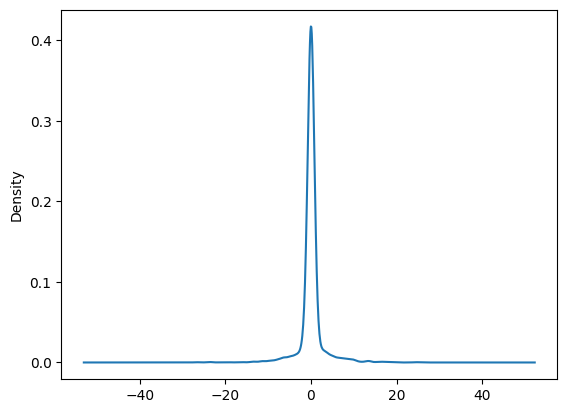

In [54]:
arima_model.resid.plot(kind='kde')

**Actual vs predicted values line plot**: 
- Checks how close are predicted values to the actual values 
- If predictions lag or overshoot actual values, model might need better `p`, `q` and `d` values 

<Axes: xlabel='date'>

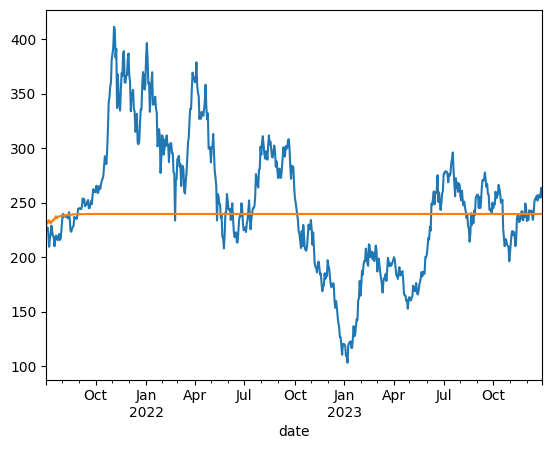

In [55]:
testdata.plot()
predictions.plot()

## SARIMAX(`S`easonal `ARIMA` with e`X`ogenous regressors) 

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot as plt

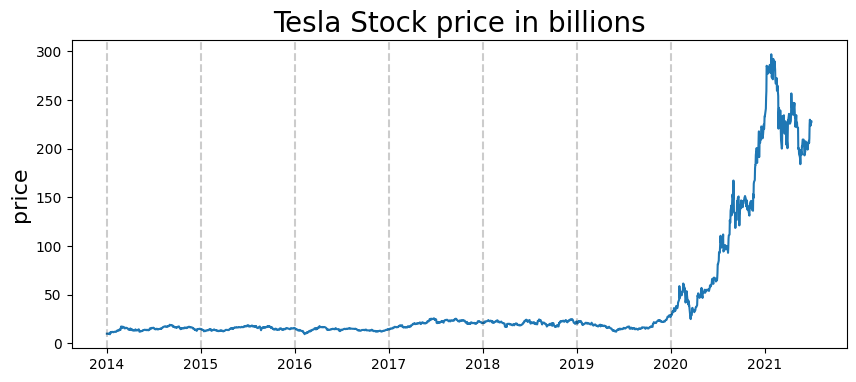

In [59]:
plt.figure(figsize=(10,4))
plt.plot(traindata)
plt.title("Tesla Stock price in billions", fontsize=20)
plt.ylabel("price", fontsize=16 )
for year in range(train_start_date.year, train_end_date.year ):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2) 

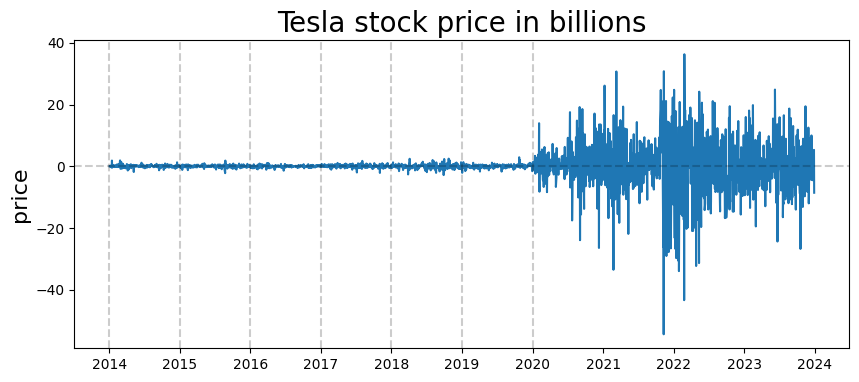

In [66]:
plt.figure(figsize=(10,4))
plt.plot(tesladf["opendiff_1"])
plt.title('Tesla stock price in billions',fontsize=20)
plt.ylabel("price", fontsize=16)
for year in range(train_start_date.year, train_end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [67]:
tesladf["seasonalopendiff_1"]=tesladf["open"]-tesladf["open"].shift(12)

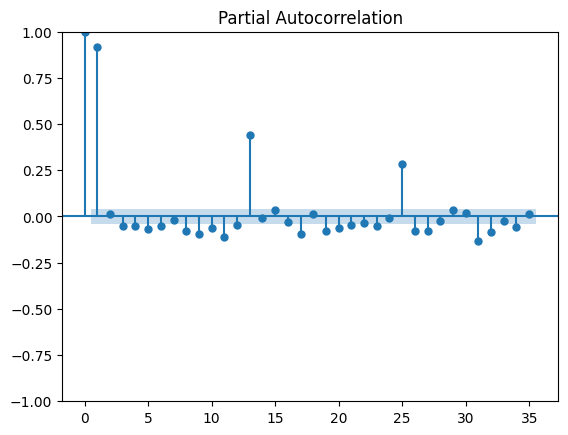

In [69]:
seasonalpacf=plot_pacf(tesladf["seasonalopendiff_1"].dropna())

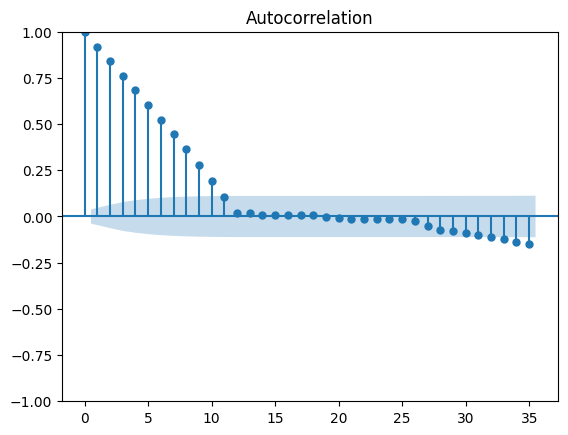

In [70]:
seasonalacf=plot_acf(tesladf["seasonalopendiff_1"].dropna())

In [ ]:
Sarimax=SARIMAX(traindata, order=(1,1,10), seasonal_order=(1,1,10,12))
sarimax_model=Sarimax.fit()